In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import joblib

%matplotlib inline

In [139]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from scipy import stats

import xgboost as xgb

import torch

## Load Dataset

In [4]:
df = pd.read_csv("./data/medicalpremium.csv")
df["PremiumPrice"] = df["PremiumPrice"] * 0.056
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,1400.0
1,60,1,0,0,0,180,73,0,0,0,1624.0
2,36,1,1,0,0,158,59,0,0,1,1288.0
3,52,1,1,0,1,183,93,0,0,2,1568.0
4,38,0,0,0,1,166,88,0,0,1,1288.0
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,840.0
982,64,1,1,0,0,153,70,0,0,3,1568.0
983,56,0,1,0,0,155,71,0,0,1,1624.0
984,47,1,1,0,0,158,73,1,0,1,2184.0


In [5]:
feature_names = df.drop("PremiumPrice", axis=1).columns.to_list()

## Exploratory Data Analysis

In [6]:
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,1362.855984
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,349.898325
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,840.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,1176.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,1288.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,1568.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,2240.000000


## Data Preparation

In [7]:
X = df.drop("PremiumPrice", axis=1).to_numpy()
y_true = df["PremiumPrice"].to_numpy()

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X

array([[45,  0,  0, ...,  0,  0,  0],
       [60,  1,  0, ...,  0,  0,  0],
       [36,  1,  1, ...,  0,  0,  1],
       ...,
       [56,  0,  1, ...,  0,  0,  1],
       [47,  1,  1, ...,  1,  0,  1],
       [21,  0,  0, ...,  1,  0,  1]], dtype=int64)

In [10]:
X_scaled

array([[ 0.23319694, -0.85075039, -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [ 1.30798124,  1.1754329 , -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [-0.41167363,  1.1754329 ,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       ...,
       [ 1.02137209, -0.85075039,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       [ 0.37650152,  1.1754329 ,  1.06498786, ...,  1.9107442 ,
        -0.36514837,  0.44423895],
       [-1.48645793, -0.85075039, -0.93897784, ...,  1.9107442 ,
        -0.36514837,  0.44423895]])

## Model Comparison

> Choosing `Decision Tree` for its explainability and `Neural Network` for showing its black box nature

### Standardization

#### Tree-based methods

In [11]:
dt_reg = DecisionTreeRegressor()

res_dict = cross_validate(dt_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=34293.75; r2=0.72
mse=31000.67; r2=0.74


In [12]:
rf_reg = RandomForestRegressor()

res_dict = cross_validate(rf_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=24850.97; r2=0.80
mse=23827.37; r2=0.81


In [13]:
xgb_reg = xgb.XGBRegressor()

res_dict = cross_validate(xgb_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=29714.54; r2=0.76
mse=29853.29; r2=0.76


#### Others

In [14]:
lin_reg = LinearRegression()

res_dict = cross_validate(lin_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(lin_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=44829.84; r2=0.63
mse=44829.84; r2=0.63


In [15]:
sgd_reg = SGDRegressor()

res_dict = cross_validate(sgd_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(sgd_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=250449372679373039511535616.00; r2=-2104822346703582527488.00
mse=44833.72; r2=0.63


In [16]:
svm_reg = SVR()

res_dict = cross_validate(svm_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(svm_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=122705.52; r2=-0.01
mse=108699.04; r2=0.11


> Standardization is not needed in tree-based methods (boost performance in general); needed in other methods

### Choosing the right explained variance ratio for PCA

The explained variance ratio is the percentage of variance that is attributed by each of the selected components.

Text(0.5, 1.0, 'The number of components needed to retain 90% variance explained')

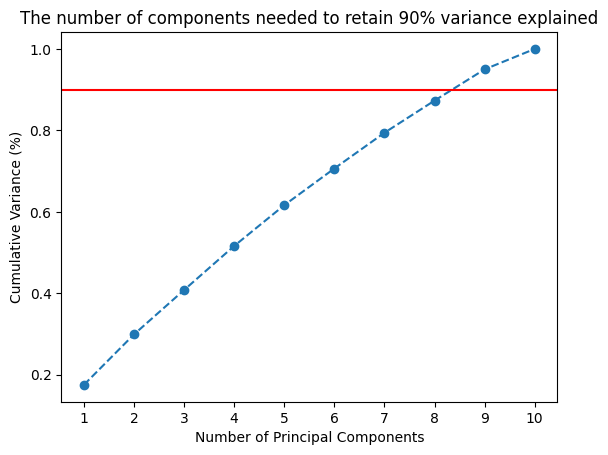

In [17]:
pca = PCA()
X_reduced = pca.fit_transform(X_scaled)
exp_var = pca.explained_variance_ratio_
cum_sum_eigvals = np.cumsum(exp_var)

plt.plot(range(1, len(cum_sum_eigvals) + 1), cum_sum_eigvals, marker="o", linestyle="--")
plt.axhline(y=0.9, color="r", linestyle="-")
plt.xticks(range(1, len(cum_sum_eigvals) + 1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance (%)")
plt.title("The number of components needed to retain 90% variance explained")

In [18]:
pca = PCA(n_components=0.9) # retain 0.9 variance explained
X_reduced = pca.fit_transform(X_scaled)

In [19]:
X_reduced.shape

(986, 9)

In [20]:
dt_reg = DecisionTreeRegressor()

res_dict = cross_validate(dt_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=90951.53; r2=0.26
mse=34917.86; r2=0.71


In [21]:
rf_reg = RandomForestRegressor()

res_dict = cross_validate(rf_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=48445.89; r2=0.60
mse=23861.24; r2=0.80


In [22]:
xgb_reg = xgb.XGBRegressor()

res_dict = cross_validate(xgb_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=53484.80; r2=0.56
mse=29853.29; r2=0.76


> PCA doesn't help to improve the performance in tree-based methods

#### Decision Tree

In [23]:
# Baseline
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=15)

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=33782.55; r2=0.72
[-0. -0. -0. -0. -0.]
[-41053.09090909 -35785.4213198  -25756.58883249 -34352.73096447
 -31964.91370558]


To reduce overfitting of Decision Tree
- set max depth
- pruning
- set min number of samples required at leaf nodes

In [24]:
params_distr = {
    "max_depth": stats.randint(low=5, high=15),
    "min_samples_leaf": stats.randint(low=2, high=20)
}

rand_search_cv = RandomizedSearchCV(DecisionTreeRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=11, min_samples_leaf=16;, score=-21960.527 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=16;, score=-32313.308 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=16;, score=-20293.472 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=16;, score=-16675.187 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=16;, score=-47030.642 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=8;, score=-22183.646 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=8;, score=-28984.217 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=8;, score=-17151.968 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=8;, score=-18972.638 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=8;, score=-44276.424 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=12;, score=-22231.828 total time=   0.0s
[CV 2/5

[CV 4/5] END max_depth=8, min_samples_leaf=16;, score=-16702.874 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=16;, score=-47026.426 total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=13;, score=-21843.861 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=13;, score=-32533.400 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=13;, score=-19480.677 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=13;, score=-16535.280 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=13;, score=-44547.191 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=16;, score=-21999.986 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=16;, score=-32313.308 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=16;, score=-20295.994 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=16;, score=-16675.187 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=16;, score=-47093.861 t

[CV 4/5] END max_depth=7, min_samples_leaf=2;, score=-19359.185 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=2;, score=-44890.443 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=11;, score=-20239.044 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=11;, score=-31527.385 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=11;, score=-18415.031 total time=   0.0s
[CV 4/5] END max_depth=9, min_samples_leaf=11;, score=-17608.368 total time=   0.0s
[CV 5/5] END max_depth=9, min_samples_leaf=11;, score=-41750.756 total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=10;, score=-20208.816 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=10;, score=-28913.288 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=10;, score=-18314.818 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=10;, score=-16513.298 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=10;, score=-42255.330 total ti

[CV 1/5] END max_depth=13, min_samples_leaf=4;, score=-28131.530 total time=   0.0s
[CV 2/5] END max_depth=13, min_samples_leaf=4;, score=-31871.596 total time=   0.0s
[CV 3/5] END max_depth=13, min_samples_leaf=4;, score=-18160.733 total time=   0.0s
[CV 4/5] END max_depth=13, min_samples_leaf=4;, score=-19129.370 total time=   0.0s
[CV 5/5] END max_depth=13, min_samples_leaf=4;, score=-48778.543 total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=7;, score=-23675.045 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=7;, score=-29514.799 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=7;, score=-17125.673 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=7;, score=-17945.144 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=7;, score=-45753.382 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=10;, score=-20393.269 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=10;, score=-28878.488 total tim

[CV 3/5] END max_depth=10, min_samples_leaf=12;, score=-18496.087 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=12;, score=-17645.448 total time=   0.0s
[CV 5/5] END max_depth=10, min_samples_leaf=12;, score=-43142.786 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=10;, score=-22999.962 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=10;, score=-36012.216 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=10;, score=-21408.881 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=10;, score=-24942.144 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=10;, score=-45908.788 total time=   0.0s
[CV 1/5] END max_depth=10, min_samples_leaf=17;, score=-23372.433 total time=   0.0s
[CV 2/5] END max_depth=10, min_samples_leaf=17;, score=-32652.407 total time=   0.0s
[CV 3/5] END max_depth=10, min_samples_leaf=17;, score=-19956.816 total time=   0.0s
[CV 4/5] END max_depth=10, min_samples_leaf=17;, score=-18971.736 tota

In [270]:
# Best model
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=11, min_samples_leaf=10)

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=25246.39; r2=0.79
[-21742.54285866 -19377.37159293 -21556.82832759 -22509.69050797
 -15909.81888523]
[-20208.8163144  -28801.21992126 -18401.69309145 -16513.29752733
 -42306.90662737]


In [276]:
dt_reg.fit(X_scaled, y_true)

y_pred = dt_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

19541.920421616032

In [277]:
joblib.dump(dt_reg, "models/decision_tree.joblib")
dt_reg = joblib.load("models/decision_tree.joblib")
y_pred = dt_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

19541.920421616032

In [278]:
dot_data = tree.export_graphviz(dt_reg, out_file=None, 
                                feature_names=feature_names, filled=True, label="all", rounded=True, proportion=True)
graph = graphviz.Source(dot_data)
graph.render("res/dtree_viz", format="pdf")
graph.render("res/dtree_viz", format="svg")

'res\\dtree_viz.svg'

#### Random Forest

In [27]:
# Baseline
rf_reg = RandomForestRegressor(random_state=42)

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=23925.35; r2=0.80
[-4416.43596345 -3244.25758175 -3469.10798682 -3699.48633714
 -2878.18979772]
[-19982.22613333 -25490.84069036 -19637.39799391 -14170.58111675
 -40345.70337462]


To reduce overfitting of Random Forest
- set max depth
- set min number of samples required at leaf nodes

In [28]:
params_distr = {
    "max_depth": stats.randint(low=5, high=15),
    "min_samples_leaf": stats.randint(low=2, high=20)
}

rand_search_cv = RandomizedSearchCV(RandomForestRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=11, min_samples_leaf=16;, score=-27825.171 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=16;, score=-33566.242 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=16;, score=-21388.669 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=16;, score=-23465.769 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=16;, score=-44748.222 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=8;, score=-20946.944 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=8;, score=-30626.667 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=8;, score=-18302.576 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=8;, score=-15652.105 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=8;, score=-43119.658 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=12;, score=-23777.989 total time=   0.0s
[CV 2/5

[CV 3/5] END max_depth=14, min_samples_leaf=3;, score=-16272.078 total time=   0.0s
[CV 4/5] END max_depth=14, min_samples_leaf=3;, score=-14751.102 total time=   0.0s
[CV 5/5] END max_depth=14, min_samples_leaf=3;, score=-44390.762 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=16;, score=-26806.416 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=16;, score=-34266.731 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=16;, score=-21533.029 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=16;, score=-23065.326 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=16;, score=-44779.357 total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=13;, score=-24240.907 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=13;, score=-32651.494 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=13;, score=-20424.975 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=13;, score=-20902.564 total t

[CV 1/5] END max_depth=13, min_samples_leaf=2;, score=-18782.815 total time=   0.0s
[CV 2/5] END max_depth=13, min_samples_leaf=2;, score=-27032.944 total time=   0.0s
[CV 3/5] END max_depth=13, min_samples_leaf=2;, score=-16677.355 total time=   0.0s
[CV 4/5] END max_depth=13, min_samples_leaf=2;, score=-13956.265 total time=   0.0s
[CV 5/5] END max_depth=13, min_samples_leaf=2;, score=-43246.869 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=12;, score=-24074.852 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=12;, score=-32075.526 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=12;, score=-19578.836 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=12;, score=-19663.762 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=12;, score=-43740.058 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-27059.616 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-34724.862 total 

[CV 4/5] END max_depth=7, min_samples_leaf=8;, score=-16893.690 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=8;, score=-43634.855 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=5;, score=-23164.516 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=5;, score=-34295.307 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=5;, score=-19861.416 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=5;, score=-21865.862 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=5;, score=-46789.942 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=8;, score=-20521.178 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=8;, score=-30748.637 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=8;, score=-18231.756 total time=   0.0s
[CV 4/5] END max_depth=9, min_samples_leaf=8;, score=-15818.690 total time=   0.0s
[CV 5/5] END max_depth=9, min_samples_leaf=8;, score=-43374.461 total time=   0.0s
[CV 

[CV 2/5] END max_depth=11, min_samples_leaf=3;, score=-27156.243 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=3;, score=-16476.614 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=3;, score=-15758.742 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=3;, score=-44330.020 total time=   0.1s
[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-27790.685 total time=   0.1s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-34398.584 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=18;, score=-21908.521 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=18;, score=-24408.601 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=18;, score=-46312.922 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=18;, score=-27979.342 total time=   0.0s
[CV 2/5] END max_depth=9, min_samples_leaf=18;, score=-34280.448 total time=   0.1s
[CV 3/5] END max_depth=9, min_samples_leaf=18;, score=-21719.868 total time=

[CV 5/5] END max_depth=7, min_samples_leaf=4;, score=-44736.950 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=8;, score=-21425.196 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=8;, score=-31274.675 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=8;, score=-18578.565 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=8;, score=-16475.129 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=8;, score=-43571.390 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=10;, score=-21996.912 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=10;, score=-31654.526 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=10;, score=-19106.995 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=10;, score=-17175.115 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=10;, score=-44062.815 total time=   0.0s
{'max_depth': 13, 'min_samples_leaf': 2} -23939.249831910576


In [279]:
# Best model
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=13, min_samples_leaf=2)

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=24251.72; r2=0.80
[-10967.08111262  -8586.95332676  -9238.49401585  -9920.28903802
  -7471.08340804]
[-19869.69727411 -27198.12723039 -16994.85260711 -14276.81429929
 -42919.12716701]


In [281]:
rf_reg.fit(X_scaled, y_true)

y_pred = rf_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

In [282]:
joblib.dump(rf_reg, "models/random_forest.joblib")
rf_reg = joblib.load("models/random_forest.joblib")
y_pred = rf_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

#### Neural Network

In [287]:
def train(X_train, y_train, X_valid, y_valid, model, n_epochs=1000, lr=0.03, verbose=False):
    
    history = {"loss_train": [], "loss_valid": []}
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        # Forward pass
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        # Model evaluation
        with torch.no_grad():
            model.eval()
            y_pred_valid = model(X_valid)
            loss_valid = criterion(y_pred_valid, y_valid)
            
        if epoch % 100 == 0:
            history["loss_train"].append(loss_train.item())
            history["loss_valid"].append(loss_valid.item())
        
        if verbose and epoch % 1000 == 0:
            tqdm.write(f'Epoch [{epoch}/{n_epochs}], Training loss: {loss_train.item():.4f}, Validation loss: {loss_valid.item():.4f}')
       
    return history

In [284]:
X_pt = torch.tensor(X_scaled, dtype=torch.float32)
y_pt = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)

In [285]:
X_train, X_valid, y_train, y_valid = train_test_split(X_pt, y_pt, test_size=0.2)

In [286]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(8, 1)
)

history = train(X_train, y_train, X_valid, y_valid, mlp, n_epochs=10000, verbose=True)

Epoch [0/10000], Training loss: 1994109.6250, Validation loss: 1925553.6250
Epoch [1000/10000], Training loss: 96644.0625, Validation loss: 68547.3906
Epoch [2000/10000], Training loss: 95921.5547, Validation loss: 69026.2266
Epoch [3000/10000], Training loss: 81356.2500, Validation loss: 69802.1953
Epoch [4000/10000], Training loss: 87367.4297, Validation loss: 75636.1562
Epoch [5000/10000], Training loss: 83362.1484, Validation loss: 75011.5469
Epoch [6000/10000], Training loss: 72357.6875, Validation loss: 76556.7188
Epoch [7000/10000], Training loss: 72744.4609, Validation loss: 81759.4688
Epoch [8000/10000], Training loss: 70135.5234, Validation loss: 79374.2500
Epoch [9000/10000], Training loss: 61470.3672, Validation loss: 78788.7344


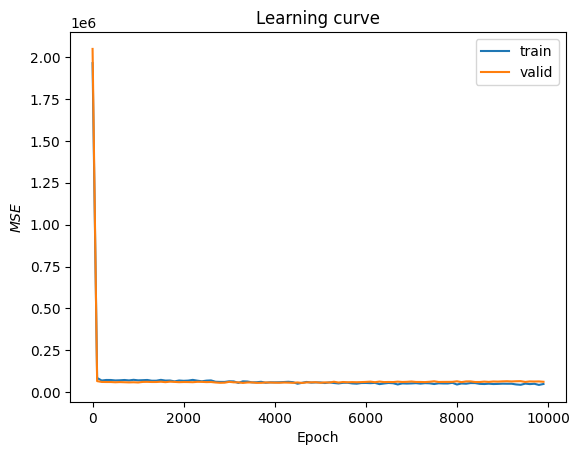

In [240]:
plt.plot(np.arange(0, len(history["loss_train"])) * 100, history["loss_train"], label="train")
plt.plot(np.arange(0, len(history["loss_train"])) * 100, history["loss_valid"], label="valid")
plt.legend()
plt.title("Learning curve")
plt.ylabel(r"$MSE$")
plt.xlabel("Epoch")
plt.show()

In [244]:
# K-fold cross validation
mse_train = []
mse_test = []

for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(X_pt, y_pt):
    
    # Get train and test data for k-th fold
    X_train_fold = X_pt[train_idx]
    y_train_fold = y_pt[train_idx]
    X_test_fold = X_pt[test_idx]
    y_test_fold = y_pt[test_idx]
    
    # Define model
    mlp = torch.nn.Sequential(
        torch.nn.Linear(10, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 8),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.1),
        torch.nn.Linear(8, 1)
    )
    
    # Train model on k-th fold training data
    history = train(X_train=X_train_fold, y_train=y_train_fold, 
          X_valid=X_test_fold, y_valid=y_test_fold, 
          model=mlp, n_epochs=10000, lr=0.03, verbose=False)
    
    mse_train.append(history["loss_train"][-1])
    mse_test.append(history["loss_valid"][-1])

In [245]:
mse_train

[62124.51171875, 57322.28515625, 50594.19921875, 46590.72265625, 36846.6328125]

In [246]:
mse_test

[52857.13671875, 41477.87890625, 67194.9375, 53807.00390625, 59751.7109375]

In [247]:
np.mean(mse_test)

55017.73359375

In [290]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(8, 1)
)

history = train(X_train=X_pt, y_train=y_pt, X_valid=X_pt, y_valid=y_pt, model=mlp, n_epochs=10000, verbose=True)

Epoch [0/10000], Training loss: 1979253.8750, Validation loss: 1978727.3750
Epoch [1000/10000], Training loss: 112487.9844, Validation loss: 35005.1758
Epoch [2000/10000], Training loss: 103977.3906, Validation loss: 33442.0234
Epoch [3000/10000], Training loss: 97959.3672, Validation loss: 38003.6914
Epoch [4000/10000], Training loss: 90520.6641, Validation loss: 29590.7383
Epoch [5000/10000], Training loss: 87619.1484, Validation loss: 26092.7090
Epoch [6000/10000], Training loss: 82040.1250, Validation loss: 26968.4922
Epoch [7000/10000], Training loss: 76749.5156, Validation loss: 19659.9805
Epoch [8000/10000], Training loss: 69246.5469, Validation loss: 18153.0762
Epoch [9000/10000], Training loss: 69281.7266, Validation loss: 15835.2529


In [291]:
print(mlp)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=8, out_features=1, bias=True)
)


In [295]:
torch.save(mlp, "models/mlp.pt")

In [296]:
mlp = torch.load("models/mlp.pt")
mlp.eval()

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=8, out_features=1, bias=True)
)

In [299]:
y_pred = mlp(torch.tensor(X_scaled, dtype=torch.float32))
torch.nn.functional.mse_loss()

tensor([[1282.0334],
        [1467.4619],
        [1223.5796],
        [1529.4094],
        [1382.9978],
        [1178.0593],
        [1214.3204],
        [ 779.3907],
        [1199.5948],
        [1308.9722],
        [1493.2051],
        [1438.5254],
        [ 794.1974],
        [1748.9565],
        [ 765.1389],
        [1227.6343],
        [1581.0706],
        [1121.2166],
        [1361.5903],
        [ 814.4869],
        [1465.0718],
        [ 884.3167],
        [1351.5518],
        [1225.4785],
        [2001.5081],
        [1143.8081],
        [ 810.7714],
        [1506.6511],
        [1194.1572],
        [1171.9343],
        [ 834.3227],
        [1092.6860],
        [ 788.1931],
        [ 666.7836],
        [1545.1023],
        [1470.0100],
        [1280.4468],
        [1324.7100],
        [1766.9404],
        [ 837.6808],
        [ 984.7286],
        [1516.9390],
        [ 773.8767],
        [1703.6265],
        [ 838.3790],
        [1331.2808],
        [1097.3623],
        [1732